In [ ]:
# Imports
import torch
from matplotlib import pyplot as plt
import sym
import numpy as np
from sym.utils import utils
plt.style.use("dark_paper")
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True 
mpl.rcParams['text.latex.preamble'] = r'\usepackage[cm]{sfmath}'
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'cm'

In [259]:
def get_filters(cnn,lcn,fc):
    weights_cnn = next(cnn.model.parameters()).detach().cpu().squeeze()
    #filters_cnn = utils.minmaxnorm(weights_cnn)
    filters_cnn = weights_cnn
    
    weights_fcn = next(fcn.model.parameters()).detach().cpu()
    #filters_fcn = utils.minmaxnorm(weights_fcn)
    filters_fcn = weights_fcn.unflatten(-1,(280,280)).numpy()

    weights_lcn = next(lcn.model.parameters()).detach().cpu().squeeze()
    weights_lcn = weights_lcn.unflatten(0,(nfilters,10,10)) #get filter locations
    weights_lcn = weights_lcn.permute(0,1,3,2,4) # height and width next to each other
    weights_lcn = weights_lcn.flatten(1,2).flatten(2,3)
    #filters_lcn = utils.minmaxnorm(weights_lcn).numpy()
    filters_lcn = weights_lcn.numpy()
    return filters_cnn, filters_lcn, filters_fcn
def get_filters2(cnn,lcn,fc,hw,hw_out):
    weights_cnn = next(cnn.model.parameters()).detach().cpu().squeeze()
    filters_cnn = utils.minmaxnorm(weights_cnn)

    weights_fcn = next(fcn.model.parameters()).detach().cpu()
    filters_fcn = utils.minmaxnorm(weights_fcn).unflatten(-1,hw).numpy()

    weights_lcn = next(lcn.model.parameters()).detach().cpu().squeeze()
    weights_lcn = weights_lcn.unflatten(0,(nfilters,*hw_out)) #get filter locations
    weights_lcn = weights_lcn.permute(0,1,3,2,4) # height and width next to each other
    weights_lcn = weights_lcn.flatten(1,2).flatten(2,3)
    filters_lcn = utils.minmaxnorm(weights_lcn).numpy()
    return filters_cnn, filters_lcn, filters_fcn

In [ ]:
testset = torch.load("./data/testset.pt")

In [ ]:
fig, axes = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(6, 3), dpi=200)
x,y = testset.tensors
for img,label, ax in zip(x,y,axes.flatten()):
    ax.imshow(img.squeeze().numpy(),cmap=plt.cm.Blues)
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(hspace=0, wspace=0.1)
fig.tight_layout()
fig.savefig("plots/data.png")
#fig.suptitle("Validation Data", y=.91)

# Non equivariant -> Uniform data trained with Adam with weight decay + calc weights
CNN accuracy on test data:   0.930 

LCN accuracy on test data:   0.153 

FCN accuracy on test data:   0.398 


In [267]:
# Load weights
nfilters = 256
stride = 28
kernel_size = 28
hidden = 64
optim=torch.optim.Adam
module = sym.models.FCN(1, out_channels=10, h=280, w=280, nfilters=nfilters,hidden=hidden,
                     kernel_size=kernel_size, stride=stride, readout_activation=None)
fcn = sym.models.Model(module, optim=optim(module.parameters()))
fcn.load_from_checkpoint("lightning_logs/MNIST/RAND/Adam/FCN/version_0/weights.cpkt-v0.ckpt", model = module, optim=optim(module.parameters()))
module = sym.models.CNN(1, out_channels=10, h=280, w=280, nfilters=nfilters,hidden=hidden,
                     kernel_size=kernel_size, stride=stride, readout_activation=None)
cnn = sym.models.Model(module,optim=optim(module.parameters()))
cnn.load_from_checkpoint("lightning_logs/MNIST/RAND/Adam/CNN/version_0/weights.cpkt.ckpt", model = module, optim=optim(module.parameters()))
module = sym.models.LCN(1, out_channels=10, h=280, w=280, nfilters=nfilters,hidden=hidden,
                     kernel_size=kernel_size, stride=stride, readout_activation=None)
lcn = sym.models.Model(module,optim=optim(module.parameters()))
lcn.load_from_checkpoint("lightning_logs/MNIST/RAND/Adam/LCN/version_0/weights.cpkt-v0.ckpt", model=module, optim=optim(module.parameters()))
print("Models loaded successfully!")

Models loaded successfully!


In [268]:
filters_cnn, filters_lcn, filters_fcn = get_filters(cnn,lcn,fcn)

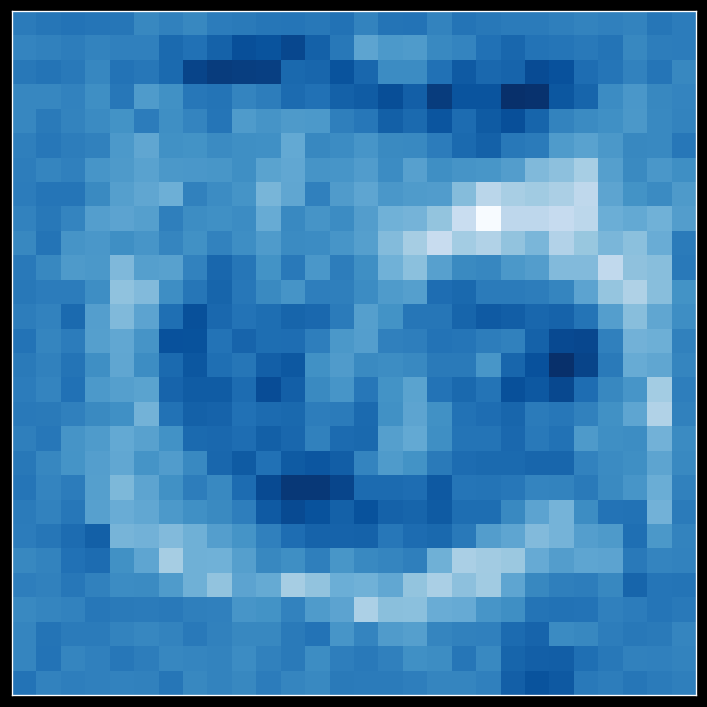

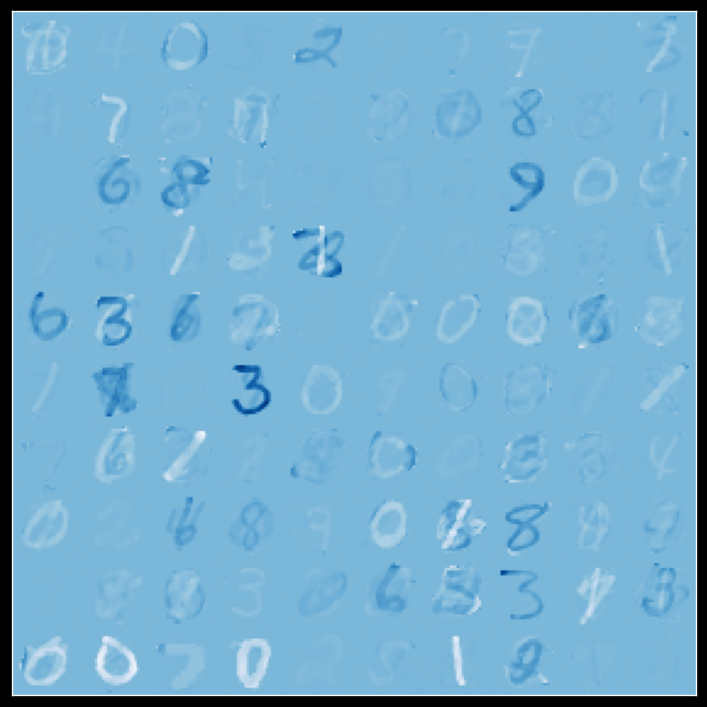

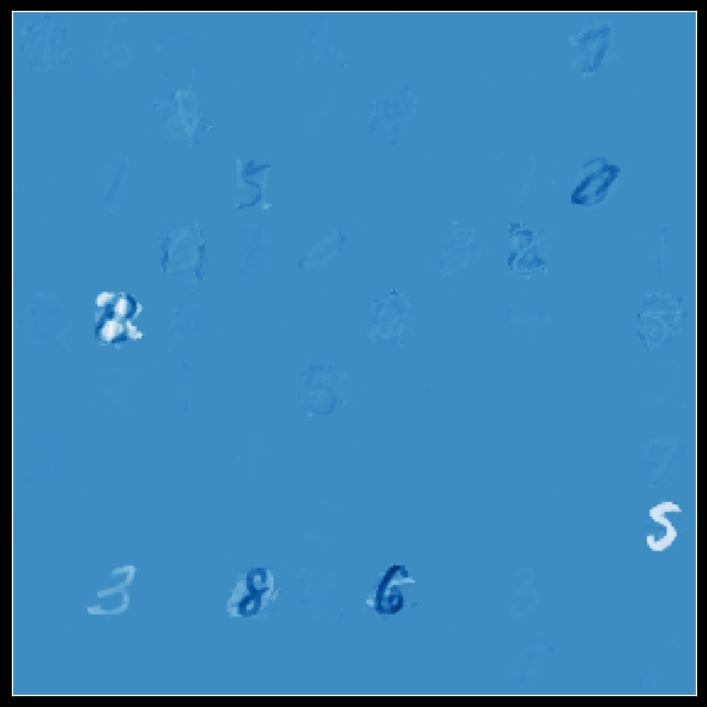

In [274]:
#plot filters 
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(6, 6), dpi=120)
for img, ax in zip(filters_cnn[5:],np.array([axes]).flatten()):
    ax.imshow(img,cmap=plt.cm.Blues)
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(hspace=0, wspace=0.1)
#fig.suptitle("LCN Filters", y=.95)
fig.tight_layout()
fig.savefig("plots/cnn_rand_w_nt.png")
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(6, 6), dpi=120)
for img, ax in zip(filters_fcn[0:],np.array([axes]).flatten()):
    ax.imshow(img,cmap=plt.cm.Blues)
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(hspace=0, wspace=0.1)
#fig.suptitle("LCN Filters", y=.95)
fig.tight_layout()
fig.savefig("plots/fcn_ran_w_n.png")
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(6, 6), dpi=120)
for img, ax in zip(filters_lcn[0:],np.array([axes]).flatten()):
    ax.imshow(img,cmap=plt.cm.Blues)
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(hspace=0, wspace=0.1)
#fig.suptitle("LCN Filters", y=.95)
fig.tight_layout()
fig.savefig("plots/lcn_ran_w_nt.png")

# Non equivariant -> Diagonal data trained with Adam with weight decay + calc weights
CNN accuracy on diag test data:   0.940 

CNN accuracy on sparse test data: 0.186 

LCN accuracy on diag test data:   0.851 

LCN accuracy on sparse test data: 0.171 

FCN accuracy on diag test data:   0.838 

FCN accuracy on sparse test data: 0.169 

In [275]:
# Load weights
nfilters = 256
stride = 28
kernel_size = 28
hidden = 64
optim=torch.optim.Adam
module = sym.models.FCN(1, out_channels=10, h=280, w=280, nfilters=nfilters,hidden=hidden,
                     kernel_size=kernel_size, stride=stride, readout_activation=None)
fcn = sym.models.Model(module, optim=optim(module.parameters()))
fcn.load_from_checkpoint("lightning_logs/MNIST/DIAG/ADAM/weights/FCN/version_0/weights.cpkt-v0.ckpt", model = module, optim=optim(module.parameters()))
module = sym.models.CNN(1, out_channels=10, h=280, w=280, nfilters=nfilters,hidden=hidden,
                     kernel_size=kernel_size, stride=stride, readout_activation=None)
cnn = sym.models.Model(module,optim=optim(module.parameters()))
cnn.load_from_checkpoint("lightning_logs/MNIST/DIAG/ADAM/weights/CNN/version_0/weights.cpkt-v0.ckpt", model = module, optim=optim(module.parameters()))
module = sym.models.LCN(1, out_channels=10, h=280, w=280, nfilters=nfilters,hidden=hidden,
                     kernel_size=kernel_size, stride=stride, readout_activation=None)
lcn = sym.models.Model(module,optim=optim(module.parameters()))
lcn.load_from_checkpoint("lightning_logs/MNIST/DIAG/ADAM/weights/LCN/version_0/weights.cpkt-v0.ckpt", model=module, optim=optim(module.parameters()))
print("Models loaded successfully!")

Models loaded successfully!


In [276]:
filters_cnn, filters_lcn, filters_fcn = get_filters(cnn,lcn,fcn)

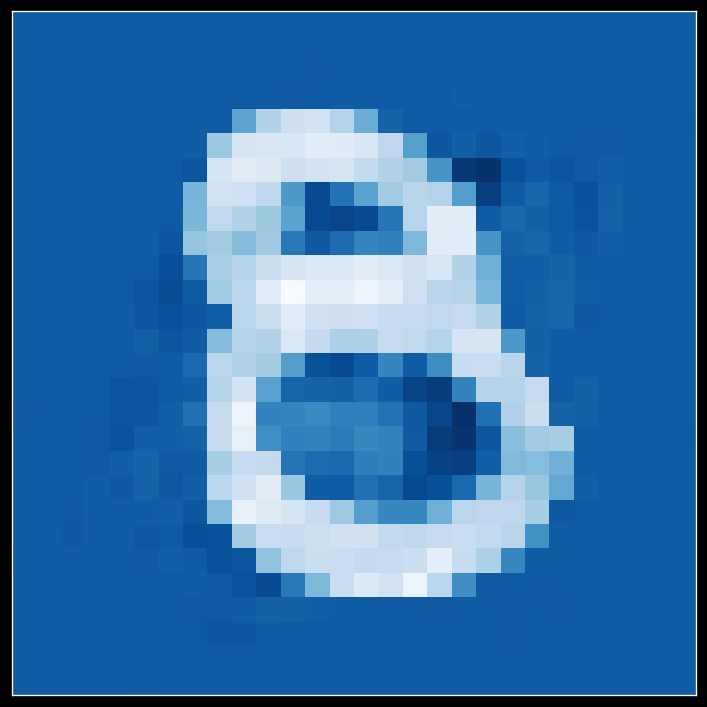

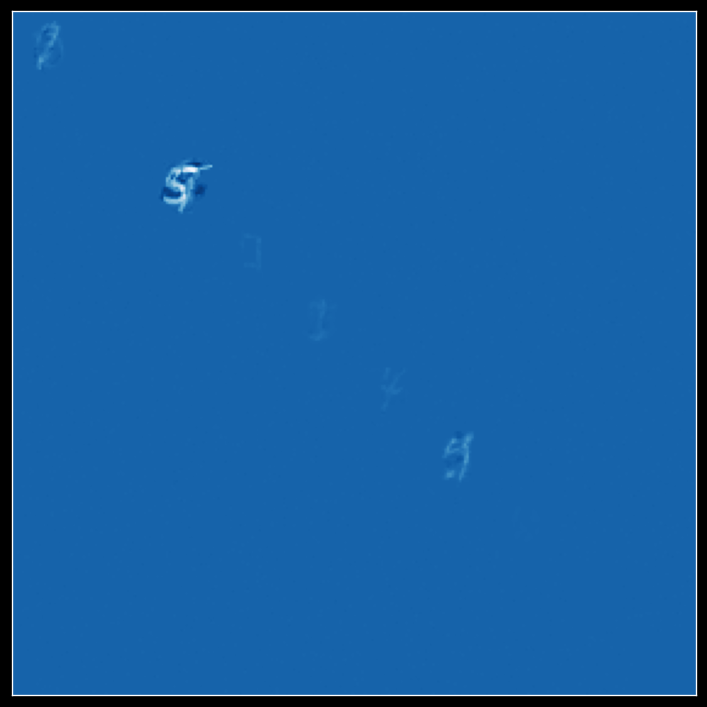

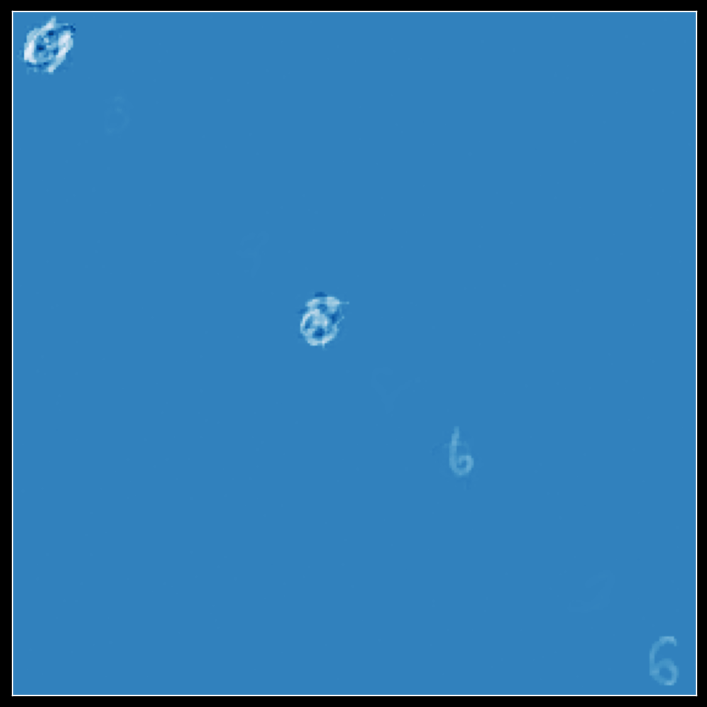

In [277]:
#plot filters 
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(6, 6), dpi=120)
for img, ax in zip(filters_cnn[3:],np.array([axes]).flatten()):
    ax.imshow(img,cmap=plt.cm.Blues)
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(hspace=0, wspace=0.1)
#fig.suptitle("LCN Filters", y=.95)
fig.tight_layout()
fig.savefig("plots/cnn_diag_w_nt.png")
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(6, 6), dpi=120)
for img, ax in zip(filters_fcn[0:],np.array([axes]).flatten()):
    ax.imshow(img,cmap=plt.cm.Blues)
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(hspace=0, wspace=0.1)
#fig.suptitle("LCN Filters", y=.95)
fig.tight_layout()
fig.savefig("plots/fcn_diag_w_n.png")
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(6, 6), dpi=120)
for img, ax in zip(filters_lcn[0:],np.array([axes]).flatten()):
    ax.imshow(img,cmap=plt.cm.Blues)
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(hspace=0, wspace=0.1)
#fig.suptitle("LCN Filters", y=.95)
fig.tight_layout()
fig.savefig("plots/lcn_diag_w_nt.png")

# Non equivariant -> Diagonal data trained with Adam
CNN accuracy on diag test data:   0.919

CNN accuracy on sparse test data: 0.177 

LCN accuracy on diag test data:   0.913 

LCN accuracy on sparse test data: 0.188 

FCN accuracy on diag test data:   0.936 

FCN accuracy on sparse test data: 0.185 

In [263]:
# Load weights
nfilters = 256
stride = 28
kernel_size = 28
hidden = 64
optim=torch.optim.Adam
module = sym.models.FCN(1, out_channels=10, h=280, w=280, nfilters=nfilters,hidden=hidden,
                     kernel_size=kernel_size, stride=stride, readout_activation=None)
fcn = sym.models.Model(module, optim=optim(module.parameters()))
fcn.load_from_checkpoint("lightning_logs/MNIST/DIAG/ADAM/FCN/version_0/weights.cpkt-v0.ckpt", model = module, optim=optim(module.parameters()))
module = sym.models.CNN(1, out_channels=10, h=280, w=280, nfilters=nfilters,hidden=hidden,
                     kernel_size=kernel_size, stride=stride, readout_activation=None)
cnn = sym.models.Model(module,optim=optim(module.parameters()))
cnn.load_from_checkpoint("lightning_logs/MNIST/DIAG/ADAM/CNN/version_0/weights.cpkt-v0.ckpt", model = module, optim=optim(module.parameters()))
module = sym.models.LCN(1, out_channels=10, h=280, w=280, nfilters=nfilters,hidden=hidden,
                     kernel_size=kernel_size, stride=stride, readout_activation=None)
lcn = sym.models.Model(module,optim=optim(module.parameters()))
lcn.load_from_checkpoint("lightning_logs/MNIST/DIAG/ADAM/LCN/version_0/weights.cpkt-v0.ckpt", model=module, optim=optim(module.parameters()))
print("Models loaded successfully!")

Models loaded successfully!


In [264]:
filters_cnn, filters_lcn, filters_fcn = get_filters(cnn,lcn,fcn)

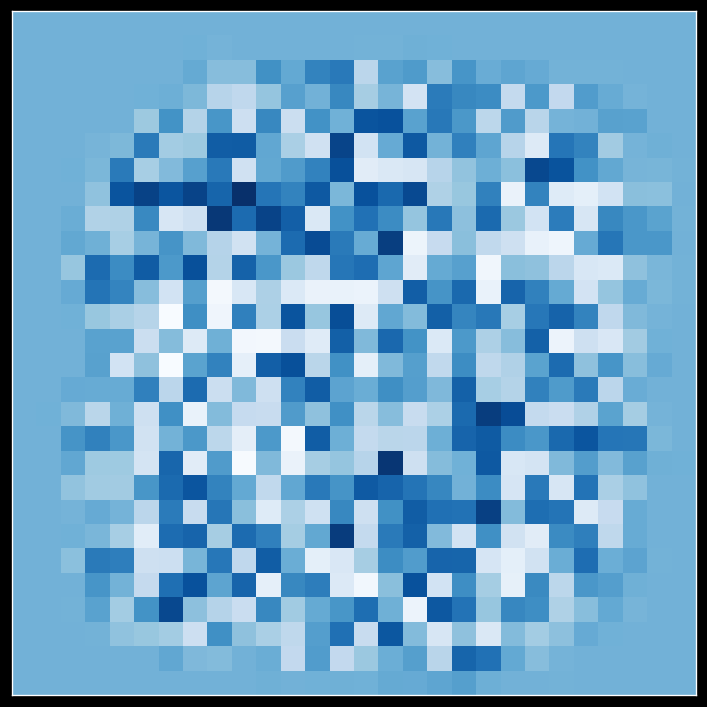

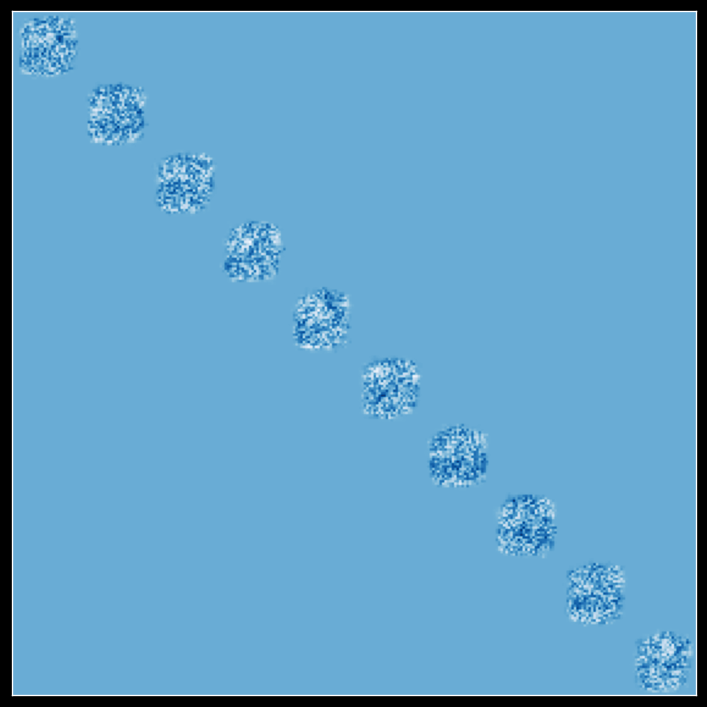

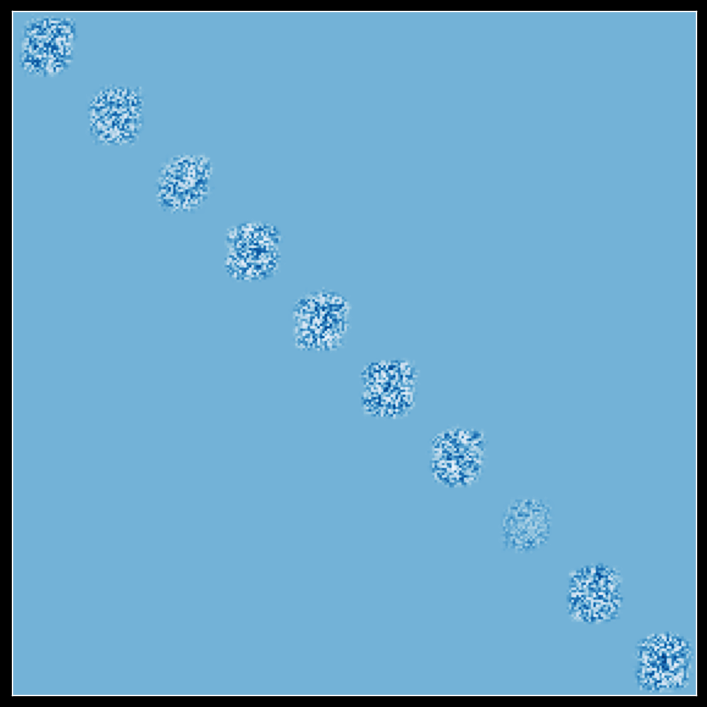

In [265]:
#plot filters 
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(6, 6), dpi=120)
for img, ax in zip(filters_cnn[3:],np.array([axes]).flatten()):
    ax.imshow(img,cmap=plt.cm.Blues)
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(hspace=0, wspace=0.1)
#fig.suptitle("LCN Filters", y=.95)
fig.tight_layout()
fig.savefig("plots/cnn_diag_nt.png")
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(6, 6), dpi=120)
for img, ax in zip(filters_fcn[0:],np.array([axes]).flatten()):
    ax.imshow(img,cmap=plt.cm.Blues)
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(hspace=0, wspace=0.1)
#fig.suptitle("LCN Filters", y=.95)
fig.tight_layout()
fig.savefig("plots/fcn_diag_nt.png")
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(6, 6), dpi=120)
for img, ax in zip(filters_lcn[200:],np.array([axes]).flatten()):
    ax.imshow(img,cmap=plt.cm.Blues)
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(hspace=0, wspace=0.1)
#fig.suptitle("LCN Filters", y=.95)
fig.tight_layout()
fig.savefig("plots/lcn_diag_nt.png")

# Non equivariant -> Diagonal data trained with SGD
(10 epochs)

CNN accuracy on diag test data:   0.887 

CNN accuracy on sparse test data: 0.182 

LCN accuracy on diag test data:   0.804

LCN accuracy on sparse test data: 0.171 

FCN accuracy on diag test data:   0.900 

FCN accuracy on sparse test data: 0.189 

In [45]:
# Load weights
nfilters = 256
stride = 28
kernel_size = 28
hidden = 64
optim=torch.optim.Adam
module = sym.models.FCN(1, out_channels=10, h=280, w=280, nfilters=nfilters,hidden=hidden,
                     kernel_size=kernel_size, stride=stride, readout_activation=None)
fcn = sym.models.Model(module, optim=optim(module.parameters()))
fcn.load_from_checkpoint("lightning_logs/MNIST/DIAG/SGD/FCN/version_0/weights.cpkt-v0.ckpt", model = module, optim=optim(module.parameters()))
module = sym.models.CNN(1, out_channels=10, h=280, w=280, nfilters=nfilters,hidden=hidden,
                     kernel_size=kernel_size, stride=stride, readout_activation=None)
cnn = sym.models.Model(module,optim=optim(module.parameters()))
cnn.load_from_checkpoint("lightning_logs/MNIST/DIAG/SGD/CNN/version_0/weights.cpkt-v0.ckpt", model = module, optim=optim(module.parameters()))
module = sym.models.LCN(1, out_channels=10, h=280, w=280, nfilters=nfilters,hidden=hidden,
                     kernel_size=kernel_size, stride=stride, readout_activation=None)
lcn = sym.models.Model(module,optim=optim(module.parameters()))
lcn.load_from_checkpoint("lightning_logs/MNIST/DIAG/SGD/LCN/version_0/weights.cpkt-v0.ckpt", model=module, optim=optim(module.parameters()))
print("Models loaded successfully!")

Models loaded successfully!


In [50]:
filters_cnn, filters_lcn, filters_fcn = get_filters(cnn,lcn,fcn)

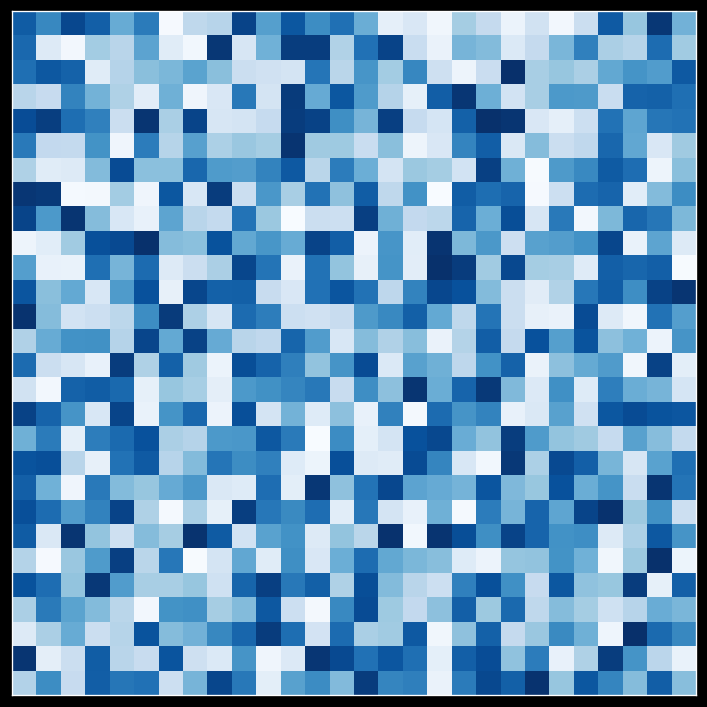

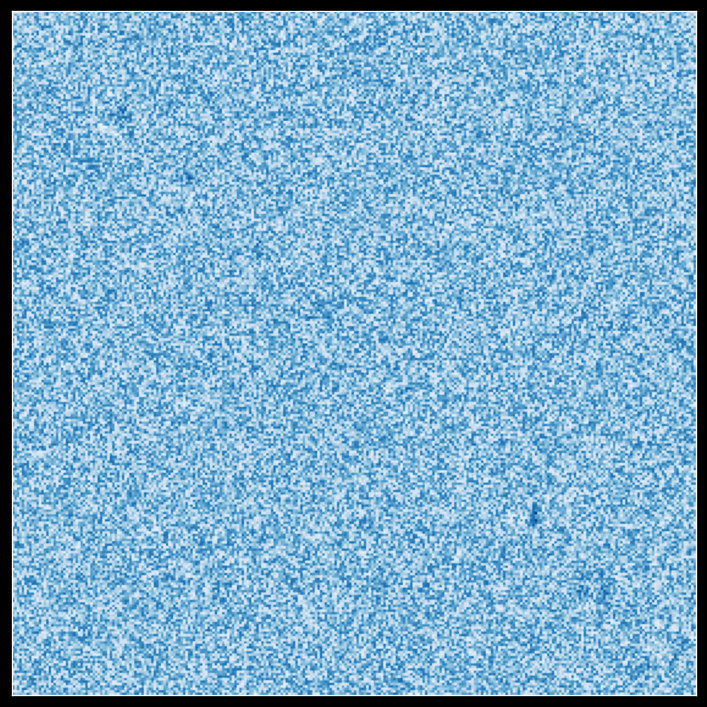

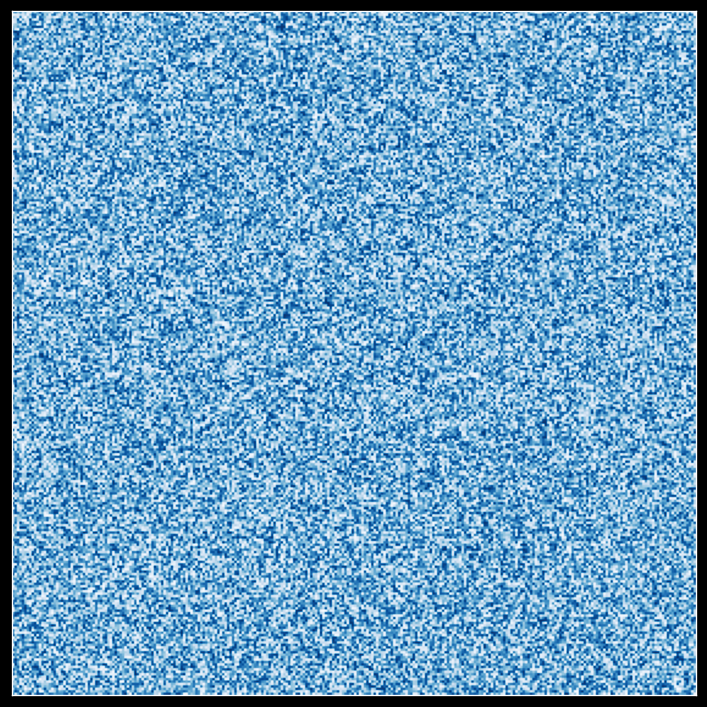

In [47]:
#plot filters 
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(6, 6), dpi=120)
for img, ax in zip(filters_cnn[3:],np.array([axes]).flatten()):
    ax.imshow(img,cmap=plt.cm.Blues)
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(hspace=0, wspace=0.1)
#fig.suptitle("LCN Filters", y=.95)
fig.tight_layout()
fig.savefig("plots/cnn_diag_nt.png")
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(6, 6), dpi=120)
for img, ax in zip(filters_fcn[0:],np.array([axes]).flatten()):
    ax.imshow(img,cmap=plt.cm.Blues)
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(hspace=0, wspace=0.1)
#fig.suptitle("LCN Filters", y=.95)
fig.tight_layout()
fig.savefig("plots/fcn_diag_nt.png")
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(6, 6), dpi=120)
for img, ax in zip(filters_lcn[200:],np.array([axes]).flatten()):
    ax.imshow(img,cmap=plt.cm.Blues)
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(hspace=0, wspace=0.1)
#fig.suptitle("LCN Filters", y=.95)
fig.tight_layout()
fig.savefig("plots/lcn_diag_nt.png")

# equivariant -> Diagonal data trained with SGD
(10 epochs)

CNN accuracy on diag test data:   0.962

CNN accuracy on sparse test data: 0.952 

LCN accuracy on diag test data:   0.843 

LCN accuracy on sparse test data: 0.179 

In [45]:
# Load weights
nfilters = 256
stride = 28
kernel_size = 28
hidden = 64
optim=torch.optim.Adam
module = sym.models.FCN(1, out_channels=10, h=280, w=280, nfilters=nfilters,hidden=hidden,
                     kernel_size=kernel_size, stride=stride, readout_activation=None)
fcn = sym.models.Model(module, optim=optim(module.parameters()))
fcn.load_from_checkpoint("lightning_logs/MNIST/DIAG-POOL/SGD/FCN/version_0/weights.cpkt-v0.ckpt", model = module, optim=optim(module.parameters()))
module = sym.models.CNN(1, out_channels=10, h=280, w=280, nfilters=nfilters,hidden=hidden,
                     kernel_size=kernel_size, stride=stride, readout_activation=None)
cnn = sym.models.Model(module,optim=optim(module.parameters()))
cnn.load_from_checkpoint("lightning_logs/MNIST/DIAG-POOL/SGD/CNN/version_0/weights.cpkt-v0.ckpt", model = module, optim=optim(module.parameters()))
module = sym.models.LCN(1, out_channels=10, h=280, w=280, nfilters=nfilters,hidden=hidden,
                     kernel_size=kernel_size, stride=stride, readout_activation=None)
lcn = sym.models.Model(module,optim=optim(module.parameters()))
lcn.load_from_checkpoint("lightning_logs/MNIST/DIAG-POOL/SGD/LCN/version_0/weights.cpkt-v0.ckpt", model=module, optim=optim(module.parameters()))
print("Models loaded successfully!")

Models loaded successfully!


In [50]:
filters_cnn, filters_lcn, filters_fcn = get_filters(cnn,lcn,fcn)

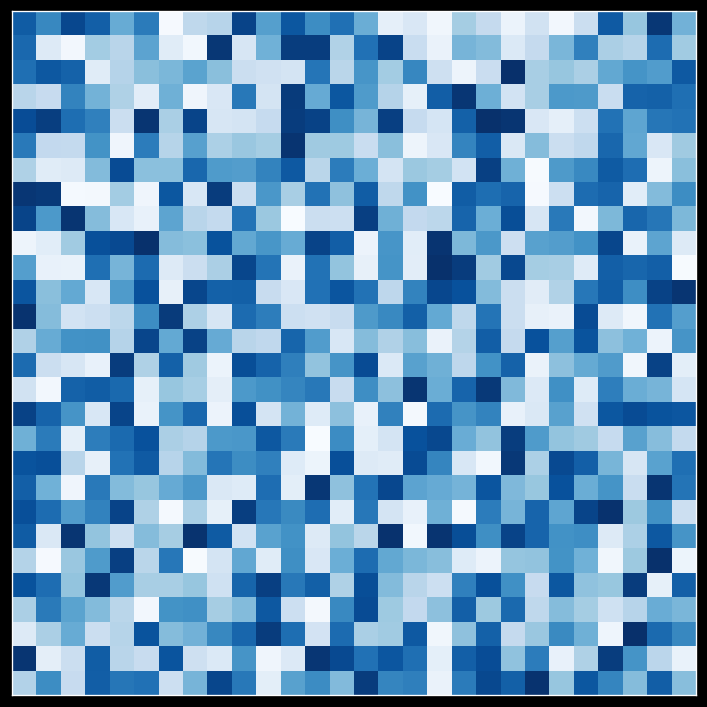

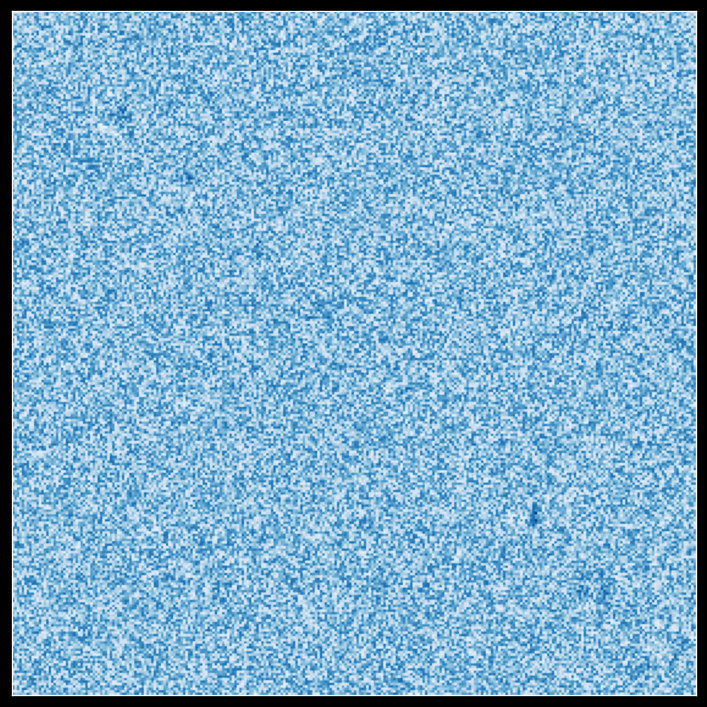

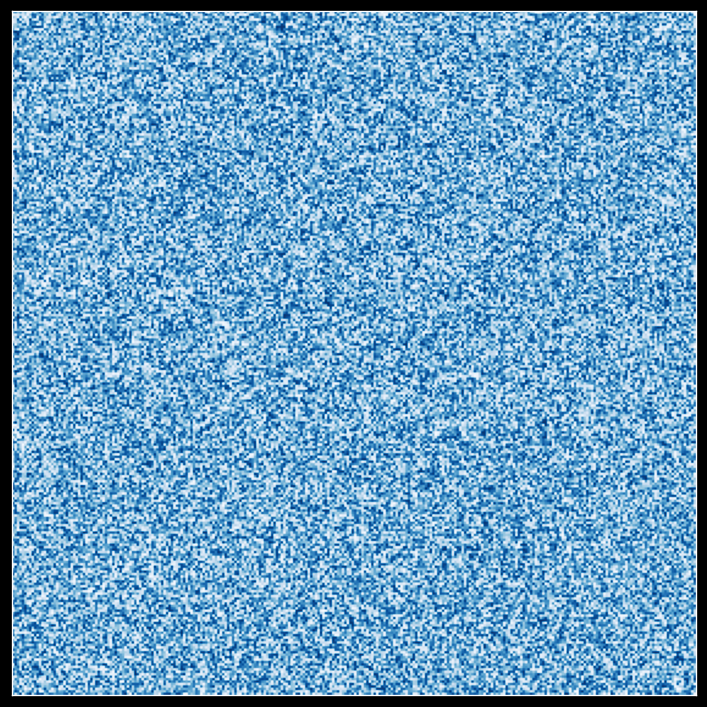

In [47]:
#plot filters 
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(6, 6), dpi=120)
for img, ax in zip(filters_cnn[3:],np.array([axes]).flatten()):
    ax.imshow(img,cmap=plt.cm.Blues)
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(hspace=0, wspace=0.1)
#fig.suptitle("LCN Filters", y=.95)
fig.tight_layout()
fig.savefig("plots/cnn_diag_nt.png")
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(6, 6), dpi=120)
for img, ax in zip(filters_fcn[0:],np.array([axes]).flatten()):
    ax.imshow(img,cmap=plt.cm.Blues)
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(hspace=0, wspace=0.1)
#fig.suptitle("LCN Filters", y=.95)
fig.tight_layout()
fig.savefig("plots/fcn_diag_nt.png")
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(6, 6), dpi=120)
for img, ax in zip(filters_lcn[200:],np.array([axes]).flatten()):
    ax.imshow(img,cmap=plt.cm.Blues)
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(hspace=0, wspace=0.1)
#fig.suptitle("LCN Filters", y=.95)
fig.tight_layout()
fig.savefig("plots/lcn_diag_nt.png")

# Parity Filters

In [153]:
"./lightning_logs/MNIST/parity/Adam/5/FCN/version_0/"

In [158]:
# Load weights
logdir = "./lightning_logs/MNIST/parity/Adam/5/CNN/version_0/"
n_digits = 5
window = (n_digits-3)//2
h_digit,w_digit = (24,8)
nfilters = 256
stride=8
kernel_size = 24
hidden = 1024
lr = 2e-4
optim = torch.optim.Adam
h_out, w_out = utils.conv_output_shape(h_w=(h_digit, w_digit*n_digits), kernel_size=kernel_size, stride=stride)
module = sym.models.FCN(1, out_channels=1, h=h_digit, w=w_digit*n_digits, nfilters=nfilters*h_out*w_out,
                        hidden=hidden,kernel_size=kernel_size, stride=stride, readout_activation=None)
efcn = sym.models.Model(module,optim=optim(module.parameters(),lr=lr))
efcn.load_from_checkpoint(path.join(logdir,"E-FCN/version_0/weights.cpkt-v0.ckpt"), model = module, optim=optim(module.parameters()))
module = sym.models.FCN(1, out_channels=1, h=h_digit, w=w_digit*n_digits, nfilters=nfilters,hidden=hidden,
                     kernel_size=kernel_size, stride=stride, readout_activation=None)
fcn = sym.models.Model(module,optim=optim(module.parameters(),lr=lr))
fcn.load_from_checkpoint(path.join(logdir,"FCN/version_0/weights.cpkt-v0.ckpt"), model = module, optim=optim(module.parameters()))
module = sym.models.CNN(1, out_channels=1, h=h_digit, w=w_digit*n_digits,#readout_activation=torch.sigmoid
                     kernel_size=kernel_size, stride=stride,nfilters=nfilters,hidden=hidden )
cnn = sym.models.Model(module,optim=optim(module.parameters(),lr=lr))
cnn.load_from_checkpoint(path.join(logdir,"CNN/version_0/weights.cpkt.ckpt"), model = module, optim=optim(module.parameters())) #uhhhhh weird name but ok
module = sym.models.LCN(1, out_channels=1, h=h_digit, w=w_digit*n_digits, nfilters=nfilters,hidden=hidden,
                     kernel_size=kernel_size, stride=stride, readout_activation=None)
lcn = sym.models.Model(module,optim=optim(module.parameters(),lr=lr))
lcn.load_from_checkpoint(path.join(logdir,"LCN/version_0/weights.cpkt-v0.ckpt"), model=module, optim=optim(module.parameters()))
print("Models loaded successfully!")

Models loaded successfully!


In [161]:
filters_cnn, filters_lcn, filters_fcn = get_filters2(cnn,lcn,fcn,hw=(h_digit,w_digit*n_digits),hw_out=(h_out,w_out))

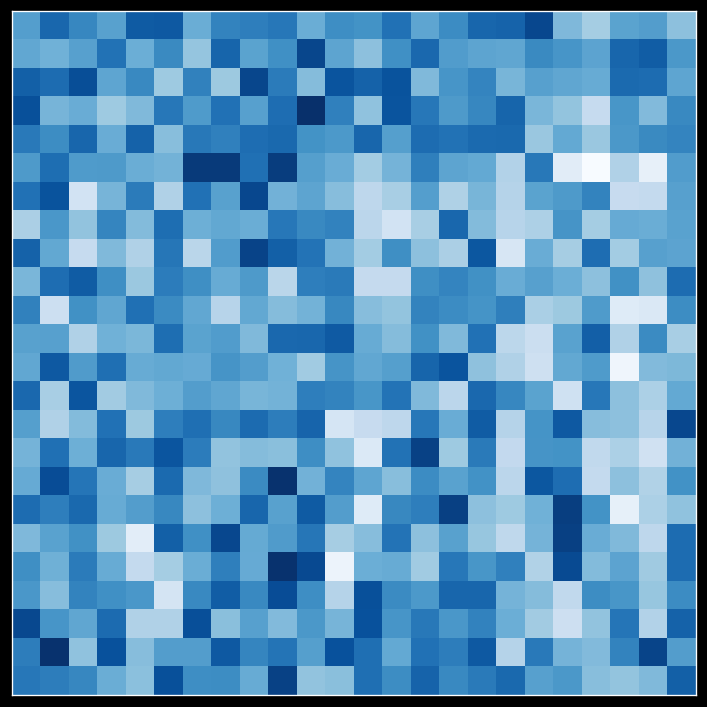

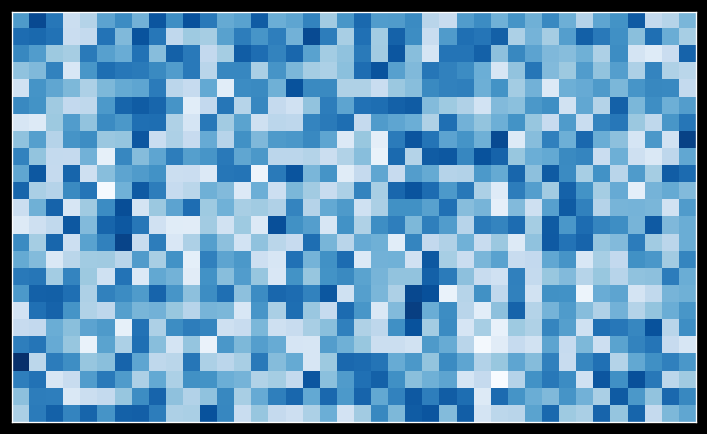

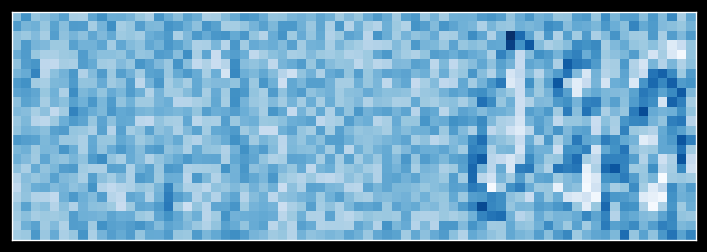

In [162]:
#plot filters 
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(6, 6), dpi=120)
for img, ax in zip(filters_cnn[0:],np.array([axes]).flatten()):
    ax.imshow(img,cmap=plt.cm.Blues)
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(hspace=0, wspace=0.1)
#fig.suptitle("LCN Filters", y=.95)
fig.tight_layout()
fig.savefig("plots/cnn_diag_nt.png")
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(6, 6), dpi=120)
for img, ax in zip(filters_fcn[0:],np.array([axes]).flatten()):
    ax.imshow(img,cmap=plt.cm.Blues)
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(hspace=0, wspace=0.1)
#fig.suptitle("LCN Filters", y=.95)
fig.tight_layout()
fig.savefig("plots/fcn_diag_nt.png")
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(6, 6), dpi=120)
for img, ax in zip(filters_lcn[200:],np.array([axes]).flatten()):
    ax.imshow(img,cmap=plt.cm.Blues)
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(hspace=0, wspace=0.1)
#fig.suptitle("LCN Filters", y=.95)
fig.tight_layout()
fig.savefig("plots/lcn_diag_nt.png")

# Bar plots

In [56]:
from sym.utils.plotting import bar_plot

In [ ]:
# CNN accuracy on test data: 0.930
# LCN accuracy on test data: 0.153
# FCN accuracy on test data: 0.398
# CNN accuracy on diag test data: 0.940
# CNN accuracy on sparse test data: 0.186
# LCN accuracy on diag test data: 0.851
# LCN accuracy on sparse test data: 0.171
# FCN accuracy on diag test data: 0.838
# FCN accuracy on sparse test data: 0.169

/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


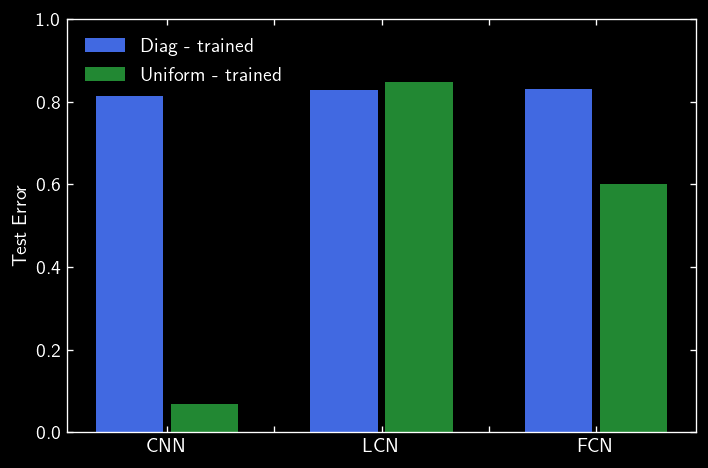

In [281]:
data = {
    "Diag - trained": 1-np.array([0.186, 0.171, 0.169]),
    "Uniform - trained": 1-np.array([0.930, 0.153,  0.398,]),
}

fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(6, 4), dpi=120)
bar_plot(ax, data, total_width=.7, single_width=.9)
ax.set_xticklabels([ "","CNN","","LCN","","FCN"])
ax.set_ylabel("Test Error")
plt.ylim([0,1])
fig.tight_layout()
fig.savefig("plots/bars_rand.png")

In [73]:
# CNN accuracy on diag test data: 0.962 pool
# CNN accuracy on diag test data: 0.887
# LCN accuracy on diag test data: 0.843 pool 
# LCN accuracy on diag test data: 0.804

# FCN accuracy on diag test data: 0.900

# CNN accuracy on uniform test data: 0.952 pool
# CNN accuracy on uniform test data: 0.182
# LCN accuracy on uniform test data: 0.179 pool 
# LCN accuracy on uniform test data: 0.171
# FCN accuracy on uniform test data: 0.189

/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


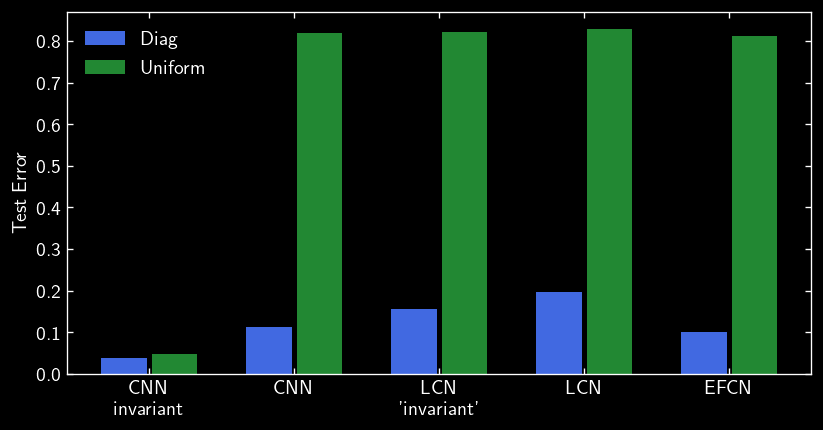

In [107]:
data = {
    "Diag": 1-np.array([0.962, .887, 0.843, 0.804,.9]),
    "Uniform": 1-np.array([.952, .182,  0.179, 0.171, .189]),
}

fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(8, 4), dpi=120)
bar_plot(ax, data, total_width=.7, single_width=.9)
ax.set_xticklabels([ "","CNN\ninvariant","CNN","LCN\n\'invariant\'","LCN","EFCN"])
ax.set_ylabel("Test Error")
plt.show()
fig.tight_layout()
fig.savefig("plots/bars.png")

In [108]:
import pandas as pd

In [218]:
# read data
params = {"ADAM_CNN":1.8401e+6,"ADAM_FCN":2.0088e+7,"ADAM_LCN":2.1735e+7,"SGD_CNN":1.8401e+6,
          "SGD_FCN":2.0088e+7,"SGD_LCN":2.1735e+7}
xs = dict()
ys = dict()
for opt in ["ADAM", "SGD"]:
    for model in ["CNN", "LCN", "FCN"]:
        df = pd.read_csv(f"data/run-DIAG_{opt}_weights_{model}_version_0-tag-zero_params.csv")
        key = "_".join([opt,model])
        xs[key] = df.Step.values
        ys[key] = df.Value.values

In [240]:
350/5

70.0

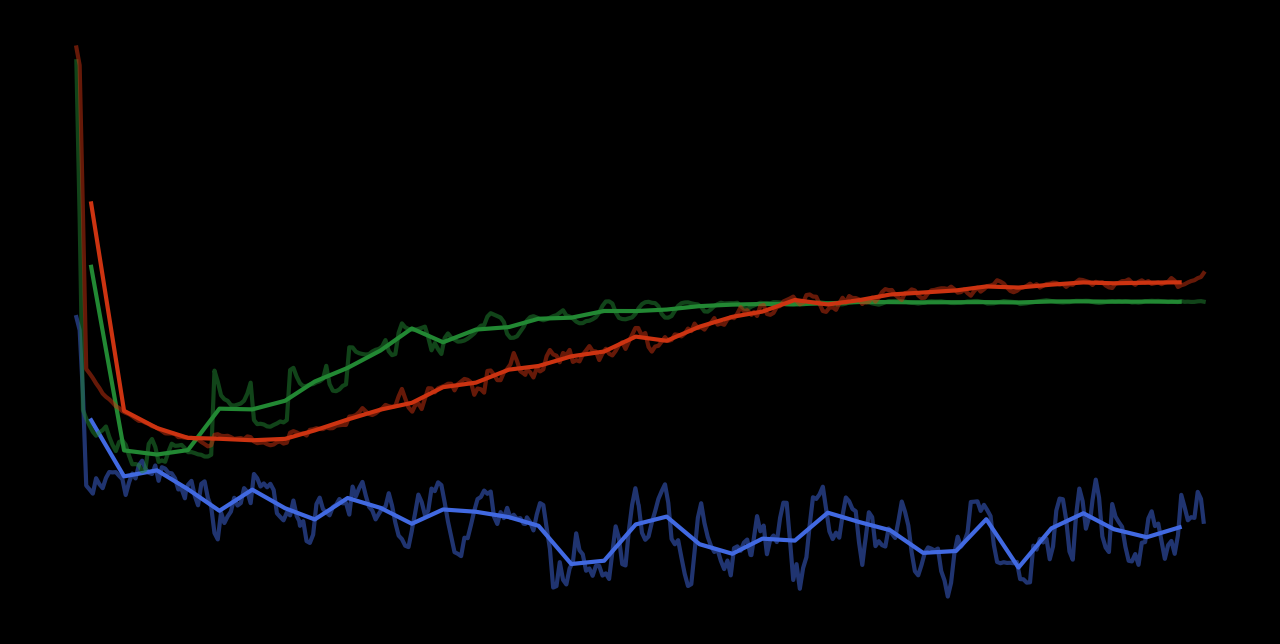

In [243]:
# plot
c= {"CNN":"royalblue","FCN":"C1","LCN":"C2"}
smoothing = 10
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(8, 4), dpi=200)
for key in params.keys():
    model = key.split("_")[1]
    if "SGD" in key: continue
    ls = "-." if "SGD" in key else "-"
    #plt.axhline(params[key],ls="--",alpha=0.5,c=c[model])
    x = xs[key]
    y = params[key]-ys[key]
    plt.plot(x,y,c=c[model],alpha=0.5)
    x = x[:350].reshape(-1,smoothing).mean(axis=1)#np.convolve(np.ones(smoothing)/smoothing,x,"same")
    y = y[:350].reshape(-1,smoothing).mean(axis=1)
    plt.plot(x,y,c=c[model])
plt.yscale("log")
plt.axis("off")
plt.show()
fig.tight_layout()
fig.savefig("plots/parameters_clear.png")

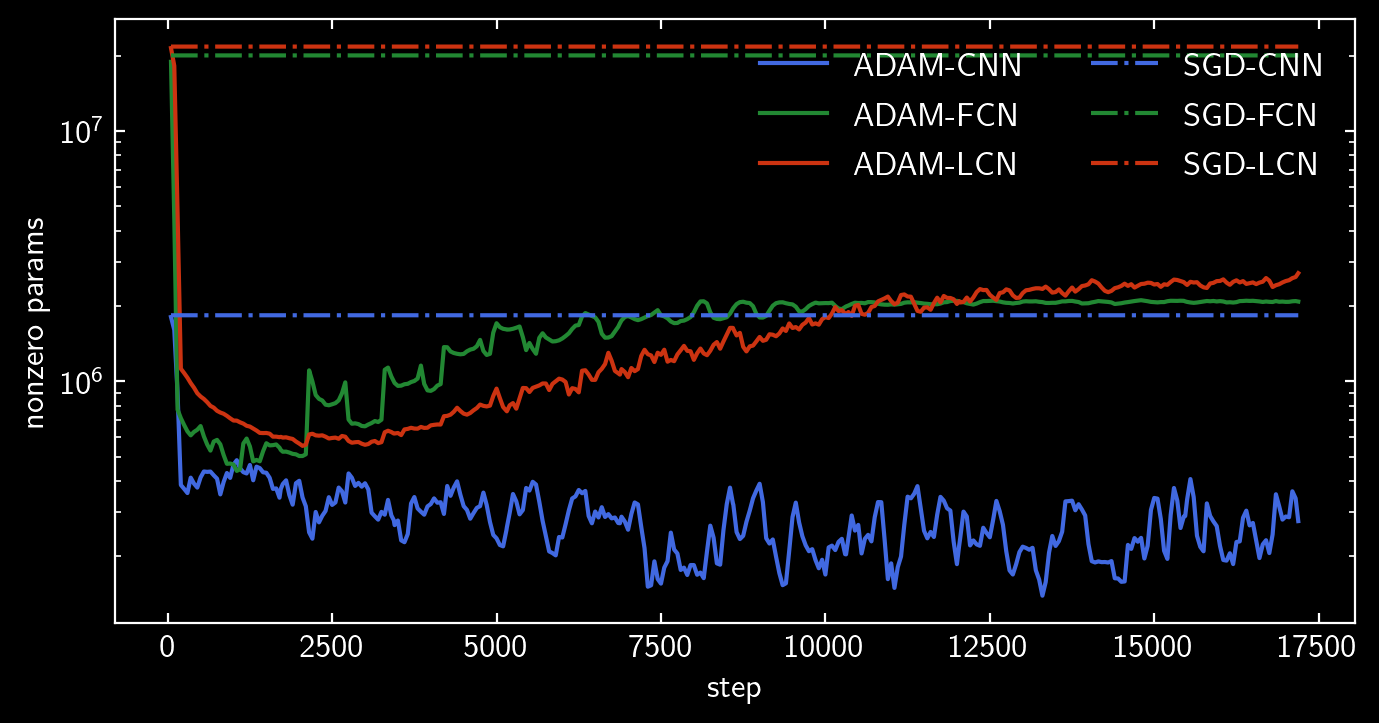

In [170]:
# plot
c= {"CNN":"royalblue","FCN":"C1","LCN":"C2"}
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(8, 4), dpi=200)
for key in params.keys():
    model = key.split("_")[1]
    ls = "-." if "SGD" in key else "-"
    #plt.axhline(params[key],ls="--",alpha=0.5,c=c[model])
    plt.plot(xs[key],params[key]-ys[key],label=key.replace("_","-"),ls=ls,c=c[model])
plt.yscale("log")
plt.legend(loc="upper right",ncol=2)
plt.xlabel("step")
plt.ylabel("nonzero params")
plt.show()
fig.tight_layout()
fig.savefig("plots/parameters.png")

In [214]:
#read data
xs = dict()
ys = dict()
nd = ["3","5","7","11"]
models = ["CNN", "LCN","E-FCN", "FCN"]
for ndigits in nd:
    for model in models:
        df = pd.read_csv(f"data/run-parity_Adam_{ndigits}_{model}_version_0-tag-val_acc.csv")
        key = "_".join([model,ndigits])
        xs[key] = df.Step.values
        ys[key] = df.Value.values

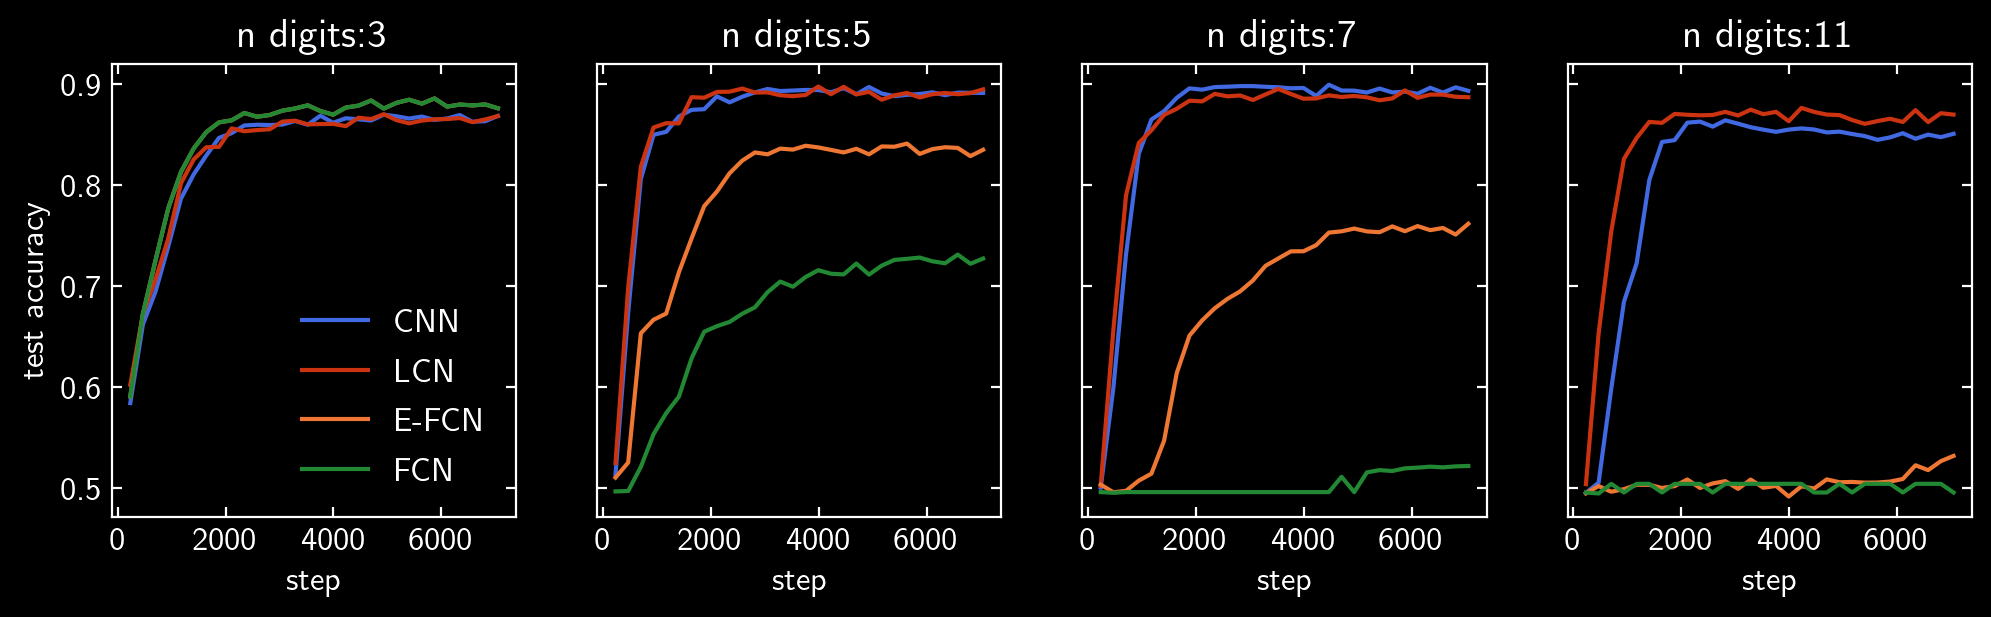

In [217]:
# plot
c= {"CNN":"royalblue","FCN":"C1","LCN":"C2","E-FCN":"C3"}
fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(12, 3), dpi=200)
for n_digits,ax in zip(nd, axes.flatten()):
    for model in models:
        key = "_".join([model,n_digits])
        #plt.axhline(params[key],ls="--",alpha=0.5,c=c[model])
        ax.plot(xs[key],ys[key],label=model,ls="-",c=c[model])
        ax.set_xlabel("step")
        ax.set_title(f"n digits:{n_digits}")
axes.flatten()[0].legend(loc="lower right",ncol=1)
axes.flatten()[0].set_ylabel("test accuracy")
plt.show()
fig.tight_layout()
fig.savefig("plots/kpattern.png")

In [203]:
# Import Data
import torchvision
from torchvision import transforms
imagenet_data_train = torchvision.datasets.MNIST("./data/", train=True)  
imagenet_data_val = torchvision.datasets.MNIST("./data/", train=False)
# data
n_digits = 11
window = (n_digits-3)//2
h_digit,w_digit = (24,8)
transform = transforms.Compose([transforms.CenterCrop((h_digit,18)),
                                transforms.Resize((h_digit,w_digit)),
                               ])
data = transform(imagenet_data_train.data)
data = data.repeat(n_digits,1,1)
mask = torch.randperm(data.shape[0])
data = data[mask].view(-1,n_digits,h_digit,w_digit) #Shuffle Data
data = data.permute(0,2,1,3).flatten(2) #Concatenate digits
data = data.unsqueeze(1)/255*2-1 # normalize data
targets = imagenet_data_train.targets.repeat(n_digits)
targets = targets[mask]
targets = targets.view(-1,n_digits)[:,window:window+3].sum(axis=1)%2
#targets = 2*targets -1 
targets = targets.view(-1,1)
trainloader =torch.utils.data.DataLoader(torch.utils.data.TensorDataset(data.float(),targets.float()),num_workers=6,
                                          batch_size=256,
                                          shuffle=True)
data = transform(imagenet_data_val.data)
data = data.repeat(n_digits,1,1)
mask = torch.randperm(data.shape[0])
data = data[mask].view(-1,n_digits,h_digit,w_digit)#[:-1]for 3 digits
data = data.permute(0,2,1,3).flatten(2)
data = data.unsqueeze(1)/255*2-1
targets = imagenet_data_val.targets.repeat(n_digits)
targets = targets[mask]
targets = targets.view(-1,n_digits)[:,window:window+3].sum(axis=1)%2 #[:-1] for 3 digits
#targets = 2*targets -1 
targets = targets.view(-1,1)
valloader =torch.utils.data.DataLoader(torch.utils.data.TensorDataset(data.float(),targets.float()),num_workers=6,
                                          batch_size=256,
                                          shuffle=False)

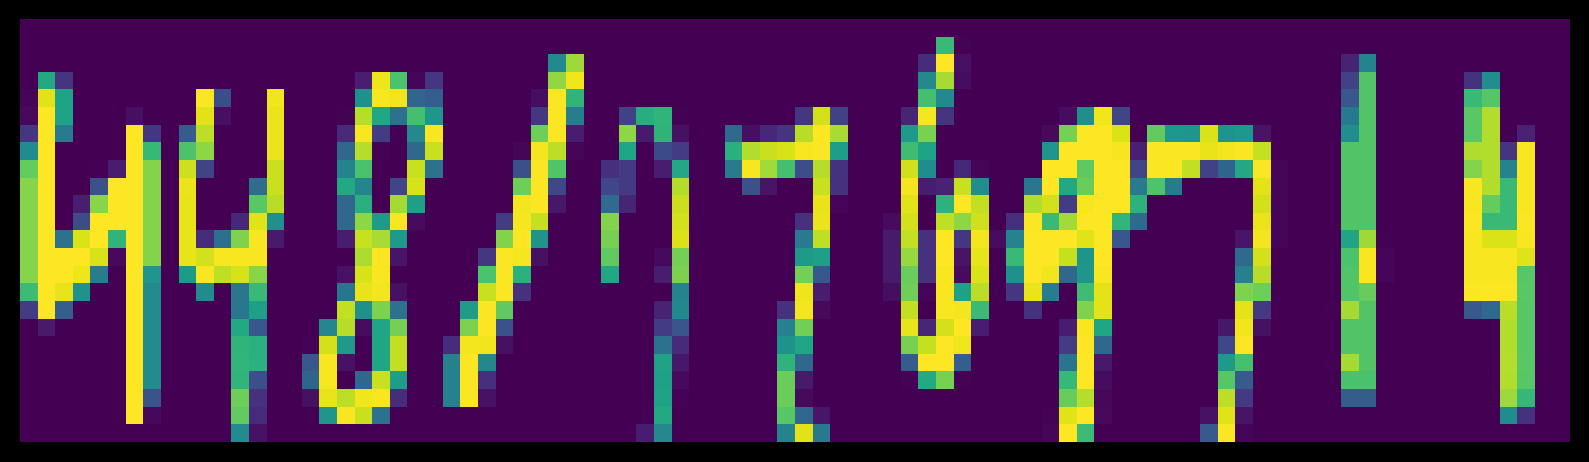

In [212]:
xs,ys =  iter(trainloader).next()
xs2,ys2 =  iter(valloader).next()
i = 0
for x,y,x2,y2 in zip(xs,ys,xs2,ys2):
    i+=1
    fig, ax = plt.subplots(1,1,figsize=(10,3),dpi=200)
    plt.imshow(x[0])
    plt.axis("off")
    if i==1: break
fig.savefig("plots/digits.png")